In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *   #lit,col,expr,regexp_extract,regexp_replace,current_date, current_timestamp,date_format
from pyspark.sql.types import StructField,StringType,StructType,DoubleType,LongType,IntegerType,FloatType,TimestampType,DataType
import pyspark
import pandas as pd

## Inicion una instancia de SPARK

In [2]:
spark= SparkSession.builder.appName("DataFrame").getOrCreate()

In [3]:
# Leo el dataset
data_bank=spark.read.csv("BankChurners.csv",sep=",",inferSchema=True,header=True)

In [4]:
#Guardo el dataset en memorio y creo una tabla temporal
data_bank.cache()
data_bank.createOrReplaceTempView("data_bank")

In [5]:
# Consulta para valores nulos
valores_nulos=[spark.sql("SELECT count({0}) as {0} FROM data_bank where {0}==NULL".format(i)).show() for i in data_bank.columns]

+---------+
|CLIENTNUM|
+---------+
|        0|
+---------+

+--------------+
|Attrition_Flag|
+--------------+
|             0|
+--------------+

+------------+
|Customer_Age|
+------------+
|           0|
+------------+

+------+
|Gender|
+------+
|     0|
+------+

+---------------+
|Dependent_count|
+---------------+
|              0|
+---------------+

+---------------+
|Education_Level|
+---------------+
|              0|
+---------------+

+--------------+
|Marital_Status|
+--------------+
|             0|
+--------------+

+---------------+
|Income_Category|
+---------------+
|              0|
+---------------+

+-------------+
|Card_Category|
+-------------+
|            0|
+-------------+

+--------------+
|Months_on_book|
+--------------+
|             0|
+--------------+

+------------------------+
|Total_Relationship_Count|
+------------------------+
|                       0|
+------------------------+

+----------------------+
|Months_Inactive_12_mon|
+------------------

In [6]:
#spark.sql("ALTER TABLE data_bank DROP COLUMN CLIENTNUM")  #Elimino datos innecesarios
data_bank=data_bank.drop(col('CLIENTNUM'),col('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'),col('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'))

## Datos descriptivos de variables continuas y discretas

In [7]:
import matplotlib.pyplot as plt
import seaborn as sb

inputcols=data_bank.drop('Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category',
'Card_Category','Credit_Limit').columns
dic={}
for i in inputcols:
    dic[i]=data_bank.stat.corr('Credit_Limit',i)    #Credit_Limit

dic

{'Customer_Age': 0.0024762273596646957,
 'Dependent_count': 0.06806460020347015,
 'Months_on_book': 0.007507009229698235,
 'Total_Relationship_Count': -0.07138581742352745,
 'Months_Inactive_12_mon': -0.020393791443455035,
 'Contacts_Count_12_mon': 0.02081701171626794,
 'Total_Revolving_Bal': 0.04249260734895825,
 'Avg_Open_To_Buy': 0.995980543932001,
 'Total_Amt_Chng_Q4_Q1': 0.012812535653393454,
 'Total_Trans_Amt': 0.17173015046794077,
 'Total_Trans_Ct': 0.07592691199468905,
 'Total_Ct_Chng_Q4_Q1': -0.0020198499941714303,
 'Avg_Utilization_Ratio': -0.4829650714174503}

<AxesSubplot:>

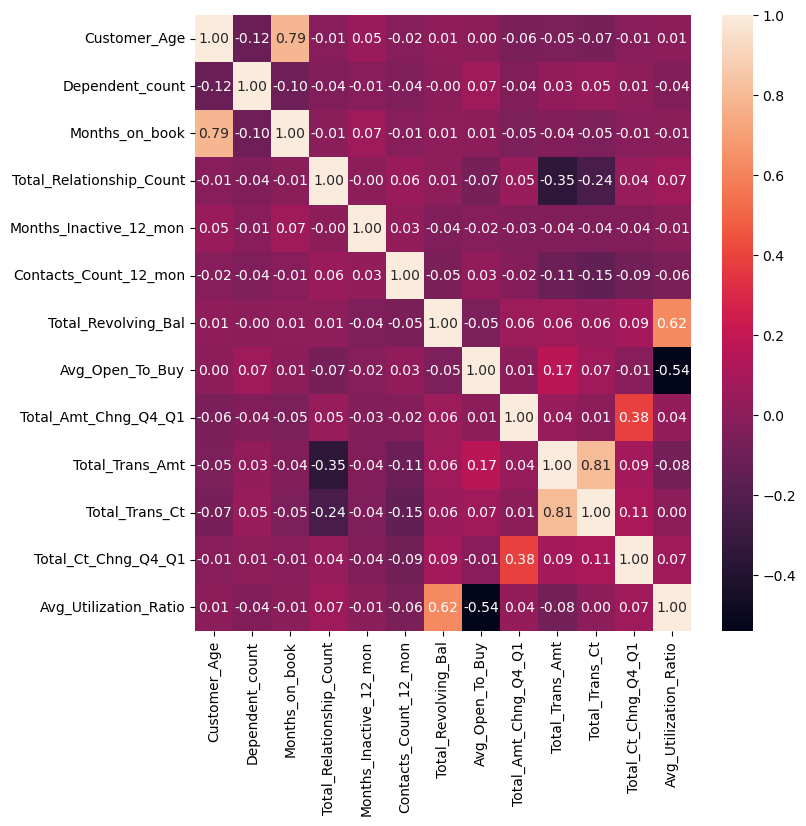

In [8]:
corr=data_bank[[inputcols]].toPandas().corr()
fig,axes=plt.subplots(figsize=(8,8))

sb.heatmap(corr,annot=True,fmt='.2f')

## Reducción de caracteristicas y dimencionalidad

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
from pyspark.ml.feature import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import MinMaxScaler

#Vector Assembler como entrada acepta discretos y continuos
inputcols=data_bank.drop('Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category',
'Card_Category','Credit_Limit').columns
outputcols='features'
asambler=VectorAssembler(inputCols=inputcols,outputCol=outputcols)
features=asambler.transform(data_bank)
features.createOrReplaceTempView('features')
features=spark.sql("""SELECT Credit_Limit as label,features 
                    FROM features""")

In [12]:
# Usamos la funcion de puntaje Chi-cuadrado int:categorica out:categorica
"""
selectionMode:"numTopFeatures"
selectionMode:"fpr" prueba p

"""
from pyspark.ml.feature import UnivariateFeatureSelector
selector=UnivariateFeatureSelector(featuresCol="features",outputCol="selectedFeatures",
                                    labelCol="label",selectionMode="fpr")

# int:continua out:continua utilizo el metodo de prueba t don valor p
selector.setFeatureType("continuous").setLabelType("continuous").setSelectionThreshold(0.05)
Prueba_t=selector.fit(features).transform(features)

In [13]:
# Usamos la funcion de puntaje Chi-cuadrado int:categorica out:categorica
"""
selectionMode:"numTopFeatures"
selectionMode:"fpr" prueba p

"""
from pyspark.ml.feature import UnivariateFeatureSelector
selector=UnivariateFeatureSelector(featuresCol="features",outputCol="numTopFeatures",
                                    labelCol="label",selectionMode="numTopFeatures")

# int:continua out:continua utilizo el metodo de prueba t don valor p
selector.setFeatureType("continuous").setLabelType("continuous").setSelectionThreshold(5)
Top=selector.fit(features).transform(features)

## Aplico ETL, normalizo y aplico pipeline

In [14]:
data_categoric=data_bank.select('Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category',
'Card_Category')
data_numeric=data_bank.drop('Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category',
'Card_Category')
data_numeric_sin_label=data_numeric.drop('Credit_Limit')

In [15]:
data_numeric_sin_label.columns

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [26]:
input_categoric=['Gender','Education_Level','Marital_Status','Income_Category',
'Card_Category']
output_category=['Gender_Bin','Education_Level_Bin ','Marital_Status_Bin','Income_Category_Bin',
'Card_Category_Bin']
input_numeric=['Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon',
 'Contacts_Count_12_mon','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
output_numeric=['Customer_Age_bin','Dependent_count_bin','Months_on_book_bin','Total_Relationship_Count_bin','Months_Inactive_12_mon_bin',
 'Contacts_Count_12_mon_bin','Total_Revolving_Bal_bin','Avg_Open_To_Buy_bin','Total_Amt_Chng_Q4_Q1_bin','Total_Trans_Amt_bin','Total_Trans_Ct_bin',
 'Total_Ct_Chng_Q4_Q1_bin','Avg_Utilization_Ratio_bin']
input_vector_asembler=data_numeric_sin_label.columns+output_category
output_vector_asembler="features"

In [34]:
category_trans=StringIndexer(inputCols=input_categoric,outputCols=output_category)
data_category_features=category_trans.fit(data_categoric).transform(data_categoric)
vector_asembler=VectorAssembler(inputCols=input_vector_asembler,outputCol=output_vector_asembler)
minmaxscaler=MinMaxScaler(min=0,max=1,inputCol=output_vector_asembler,outputCol="Features")

In [61]:
# Define los porcentajes de partición
p1 = 0.6  # 60%
p2 = 0.2  # 20%

# Divide el DataFrame en tres DataFrames más pequeños utilizando el método sample
data_train = data_bank.sample(False, p1)
data_test = data_bank.sample(False, p2)
from pyspark.ml.regression import LinearRegression
LR=LinearRegression(featuresCol="Features",labelCol="Credit_Limit",maxIter=10,regParam=0.3,elasticNetParam=0.8)

## Modelo de regresion lineal

In [63]:
Pipeline_LR=Pipeline(stages=[category_trans,vector_asembler,minmaxscaler,LR])
Model_LR=Pipeline_LR.fit(data_train)

In [78]:
prediccion_LR=Model_LR.transform(data_test).select("Credit_Limit","prediction")

In [106]:
data=[('Existing Customer', 45, 'M', 7, 'Graduate', 'Single',
       'Less than $40K', 'Blue', 35, 6, 1, 2, 8256.0, 700, 7392.0, 1.541,
       1000, 33, 3.714, 0.105)]
column=data_bank.columns

In [109]:
dato=spark.createDataFrame(data,column)

In [112]:
Model_LR.transform(dato).select("Credit_Limit","prediction").show()

+------------+-----------------+
|Credit_Limit|       prediction|
+------------+-----------------+
|      8256.0|7931.703932229084|
+------------+-----------------+



In [79]:
intercept=Model_LR.stages[-1].intercept
coefic=Model_LR.stages[-1].coefficients

In [85]:
from pyspark.ml.evaluation import RegressionEvaluator
LR_evaluater=RegressionEvaluator(labelCol="Credit_Limit",predictionCol="prediction",metricName="rmse")
LR_evaluater.evaluate(prediccion_LR)

45.16593405814147

## Desicion Tree Model

In [88]:
from pyspark.ml.regression import DecisionTreeRegressor
DT=DecisionTreeRegressor(featuresCol="Features",labelCol="Credit_Limit")

In [89]:
Pipeline_DT=Pipeline(stages=[category_trans,vector_asembler,minmaxscaler,DT])
Model_DT=Pipeline_DT.fit(data_train)
prediccion_DT=Model_DT.transform(data_test).select("Credit_Limit","prediction")

In [90]:
DT_evaluater=RegressionEvaluator(labelCol="Credit_Limit",predictionCol="prediction",metricName="rmse")
DT_evaluater.evaluate(prediccion_DT)

741.7609213526339

In [ ]:
from pyspark.ml.feature import PCA

input="std_features"
output="selectrdFeatures"

PCAselector=PCA(inputCol=input,outputCol=output,k=3)


In [ ]:
Final=PCAselector.fit(result)

In [ ]:
Final.transform(result)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(predictionCol="prediction",labelCol="label",metricName="rmse")
evaluator.evaluate(prediccion)